In [ ]:
!pip install lmdb numba joblib scipy tqdm opencv-python gdown faiss-cpu Pillow

     |████████████████████████████████| 8.6 MB 14.7 MB/s 


In [ ]:
!gdown --id 15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ
To: /content/archive_scenery.zip
100% 650M/650M [00:04<00:00, 136MB/s]


In [ ]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive_scenery.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 3.94 s, sys: 1.39 s, total: 5.33 s
Wall time: 6.15 s


convert filenames to sequential ids

In [ ]:
import os
n = 1
FILE_PATH="./scenery/"
from tqdm import tqdm
file_names = os.listdir(FILE_PATH)
file_names.sort()
for file_name in tqdm(file_names):
    oldext = os.path.splitext(file_name)[1]
    os.rename(FILE_PATH+file_name, FILE_PATH + str(n) + oldext)
    n += 1

100%|██████████| 4319/4319 [00:00<00:00, 24695.28it/s]


calculate phashes, store in lmdb


In [ ]:
from scipy.fft import dct
import cv2
import numpy as np
from numba import jit
from os import listdir
from joblib import Parallel, delayed
from tqdm import tqdm
import lmdb

def int_to_bytes(x: int) -> bytes:
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')

DB = lmdb.open('./phashes.lmdb',map_size=500*1_000_000) #500mb
IMAGE_PATH = "./scenery"

def check_if_exists_by_id(id):
    with DB.begin(buffers=True) as txn:
        x = txn.get(int_to_bytes(id),default=False)
        if x:
            return True
        return False

@jit(cache=True, nopython=True)
def diff(dct, hash_size):
    dctlowfreq = dct[:hash_size, :hash_size]
    med = np.median(dctlowfreq)
    diff = dctlowfreq > med
    return diff.flatten()


def fast_phash(image, hash_size=24, highfreq_factor=4): #hash_size=16 for 256bit #hash_size=8 for 64bit
    img_size = hash_size * highfreq_factor
    image = cv2.resize(image, (img_size, img_size), interpolation=cv2.INTER_AREA)  # cv2.INTER_AREA
    dct_data = dct(dct(image, axis=0), axis=1)
    return diff(dct_data, hash_size)


@jit(cache=True, nopython=True)
def bit_list_to_72_uint8(bit_list_576):
    uint8_arr = []
    for i in range(len(bit_list_576)//8):
        bit_list = []
        for j in range(8):
            if(bit_list_576[i*8+j] == True):
                bit_list.append(1)
            else:
                bit_list.append(0)
        uint8_arr.append(bit_list_to_int(bit_list))
    return np.array(uint8_arr, dtype=np.uint8)


@jit(cache=True, nopython=True)
def bit_list_to_int(bitlist):
    out = 0
    for bit in bitlist:
        out = (out << 1) | bit
    return out


def get_phash(query_image):
    bit_list_576 = fast_phash(query_image)
    phash = bit_list_to_72_uint8(bit_list_576)
    return phash

def calc_phash(file_name):
    file_id = int(file_name[:file_name.index('.')])
    img_path = IMAGE_PATH+"/"+file_name
    try:
        query_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        phash = get_phash(query_image)
        return (int_to_bytes(file_id), phash.tobytes())
    except:
        print("error")
        print(file_name)
        return None


file_names = listdir(IMAGE_PATH)
file_names.sort()
print(f"images in {IMAGE_PATH} = {len(file_names)}")
new_images = []

for file_name in tqdm(file_names):
    file_id = int(file_name[:file_name.index('.')])
    if check_if_exists_by_id(file_id):
        continue
    new_images.append(file_name)

print(f"new images = {len(new_images)}")
new_images = [new_images[i:i + 100000] for i in range(0, len(new_images), 100000)]
for batch in new_images:
    phashes = Parallel(n_jobs=-1, verbose=1)(delayed(calc_phash)(file_name) for file_name in batch)
    phashes = [i for i in phashes if i]  # remove None's
    print("pushing data to db")
    with DB.begin(write=True, buffers=True) as txn:
        with txn.cursor() as curs:
            curs.putmulti(phashes)

images in ./scenery = 4319


100%|██████████| 4319/4319 [00:00<00:00, 201557.69it/s]

new images = 4319



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed:   30.0s


pushing data to db


[Parallel(n_jobs=-1)]: Done 4319 out of 4319 | elapsed:   44.9s finished


add to faiss index

In [ ]:
from tqdm import tqdm
import numpy as np
import lmdb
import faiss
DB_features = lmdb.open("phashes.lmdb", readonly=True)
dim = 72
faiss_dim = dim*8
quantizer = faiss.IndexBinaryFlat(faiss_dim)
index = faiss.IndexBinaryIDMap2(quantizer)
def int_from_bytes(xbytes: bytes) -> int:
    return int.from_bytes(xbytes, 'big')

def get_all_data_iterator(batch_size=10000):
    with DB_features.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            temp_ids = np.zeros(batch_size,np.int64)
            temp_features = np.zeros((batch_size,dim),np.uint8)
            retrieved = 0
            for data in curs.iternext(keys=True, values=True):
                temp_ids[retrieved] = int_from_bytes(data[0])
                temp_features[retrieved] = np.frombuffer(data[1],dtype=np.uint8)
                retrieved+=1
                if retrieved == batch_size:
                    retrieved=0
                    yield temp_ids, temp_features
            if retrieved != 0:
                yield temp_ids[:retrieved], temp_features[:retrieved]

for ids, features in tqdm(get_all_data_iterator(100000)):
    index.add_with_ids(features,ids)
faiss.write_index_binary(index,"populated.index")

1it [00:00, 55.83it/s]


Search

In [ ]:
query_image = cv2.imread(IMAGE_PATH+"/198.jpg", cv2.IMREAD_GRAYSCALE)
query_phash = get_phash(query_image)

In [ ]:
print(query_phash)

[249   1 102 121 163 116  16 178  28  63 104 116 180 104  84 140 250  30
   8 211  31  45 239  50 212 107 134 106  87  15  42 102  99 222 107 244
 222 114 239  72  58 125 195 107  39  70  87 165  34  16 141 226   8 140
 119 129 156  47 192 221 205 240  24 217 240  58  47 241 180 170 120 137]


In [ ]:
index = faiss.read_index_binary("./populated.index")
D, I = index.search(query_phash.reshape(1,-1), 10)
# lims, D, I = index.range_search(query_phash.reshape(1,-1), 64)

In [ ]:
print("distances")
print(D)
print("indexes")
print(I)

distances
[[  0   0   0 242 246 248 250 252 252 252]]
indexes
[[ 263  293  198 1500 2665 3838 3110 2019  533 1941]]


In [ ]:
from PIL import Image
images_np=[]
for image_id in I[0]:
  images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_id}.jpg')))

# for image_id in I:
#   images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_id}.jpg')))

In [ ]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

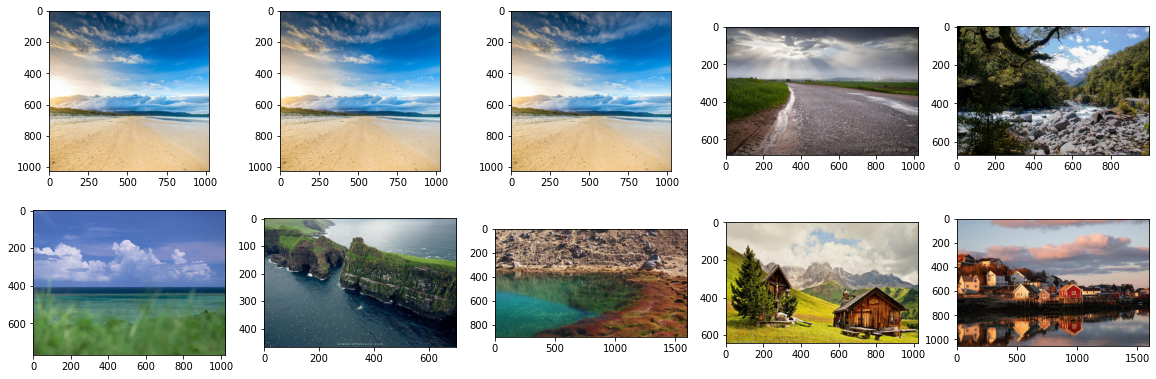

In [ ]:
show_images(images_np)